In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import geopandas
import matplotlib.colors as pltc
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

This Jupyther notebook set the framework for the FOPI derivation. It also perform the first testing using ROC and reliability metrics 
The dataset to run the scripts is available at zenodo 

https://doi.org/10.5281/zenodo.6572507 release v1.0.0 

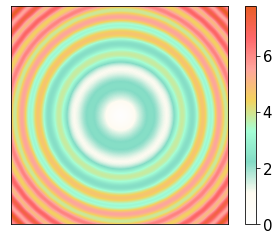

In [2]:
#Some graphics resources 

class txt_color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp =LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
hex_list = ["#fffcf2","#ccc5b9","#403d39","#252422","#eb5e28"]
hex_list =["#ffffff","#faf0ca","#f4d35e","#ee964b","#f95738","#eb5e28"]

hex_list =["#ffffff","#fffcf2","#84dcc6","#a5ffd6","#f4d35e","#ffa69e","#ff686b","#eb5e28"]
fig, ax = plt.subplots(1,1)
im = ax.imshow(z, cmap=get_continuous_cmap(hex_list))
fig.colorbar(im)
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks
# colour palette


Data upload from 2020 datacube 

available at 
https://doi.org/10.5281/zenodo.6572507 release v1.0.0 


In [3]:
data_dir='/perm/nen/2020_fire_datacube/'

In [4]:
biomes=xr.open_dataset(data_dir+"biomes_grouped_50km.nc")
#fire activity
activefires=xr.open_dataset(data_dir+"activefire_2020_50km.nc")
burned_area=xr.open_dataset(data_dir+"2020-C3S-L4_FIRE-BA-OLCI-fv1.1_50km.nc")
#vegetation 
vod=xr.open_dataset(data_dir+"2020_VOD_runmean5_50km_timeint.nc")
lai=xr.open_dataset(data_dir+"CGLS_LAI_v2_2020_daily_50km.nc")
#Fire weather indices 
fwi=xr.open_dataset(data_dir+"FWI_2020_50km.nc")
ffmc=xr.open_dataset(data_dir+"FFMC_2020_50km.nc")
dmc=xr.open_dataset(data_dir+"DMC_2020_50km.nc")
dc=xr.open_dataset(data_dir+"DC_2020_50km.nc")
isi=xr.open_dataset(data_dir+"ISI_2020_50km.nc")
bui=xr.open_dataset(data_dir+"BUI_2020_50km.nc")

In [5]:
#fire activity
af=activefires.var98.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
ba=burned_area.burned_area.to_dataframe().reset_index().drop(columns=['time','lat','lon'])

#fire indices
fwi=fwi.fwi.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
ffmc=ffmc.ffmc.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
dmc=dmc.dmc.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
dc=dc.dc.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
isi=isi.isi.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
bui=bui.bui.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
#vegetation 
vod=vod.SM_IDW.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
lai=lai.LAI.to_dataframe().reset_index().drop(columns=['time','lat','lon'])
#biomes
bio=biomes.var1.to_dataframe().reset_index().drop(columns=['time','lat','lon'])



Fopi definition 

The fire occurrence probability index (FOPI) is defined as the ratio of occurred fires per simultaneous occurrence of weather and fuel conditions. FOPI expresses a probability that a fire is observed when certain conditions are met and, establishes a link between the landscape status, the weather and the observed fires activity. FOPI analytical relationship to the controlling variables is derived using a parametric non-linear least squares  fit over a training data-set (80 \% of the sample) extracted from the data collected in 2020.

Looking at the frequency of occurrence between vod/lai and fire weather indices non/considering the fires event 

In [6]:
df=pd.DataFrame()
df["af"]=af.var98
df["ba"]=ba.burned_area
df["fwi"]=fwi.fwi
df["ffmc"]=ffmc.ffmc
df["dc"]=dc.dc
df["dmc"]=dmc.dmc
df["isi"]=isi.isi
df["bui"]=bui.bui
df["lai"]=lai.LAI
df["vod"]=vod.SM_IDW

df["bio"]=np.resize(np.array(bio), df.shape[0])
df.loc[df['fwi']==0]=0.001

df["Bio_Names"]=""
df.loc[df['bio'] ==1, "Bio_Names"] = "Savanna"
df.loc[df['bio'] ==2, "Bio_Names"] = "Agriculture"
df.loc[df['bio'] ==3, "Bio_Names"] = "Forest"

df=df.dropna(axis=0, how='any')

#split between training and testing

In [7]:

training_df = df.sample(frac=0.8, random_state=25)
testing_df = df.drop(training_df.index)

Training 

In [8]:
#better to have a linear variable for FWI..transform with log
training_df['fwi']=np.log(df.fwi)
#the vegetation variable needs to be normalised so we can either use VOD or LAI or any other indicators
#training_df['vod']=(df.vod)/np.max(df.vod)
#training_df['lai']=(df.lai)/np.max(df.lai)
#(training_df.lai)

44492172    0.000000
20412123    0.000000
21162370    0.000000
64142518    6.360606
61642227    1.766667
              ...   
34949760    1.443319
7130731     3.033303
33356290    0.266664
52585036    0.533333
50417353    0.033333
Name: lai, Length: 10637365, dtype: float32

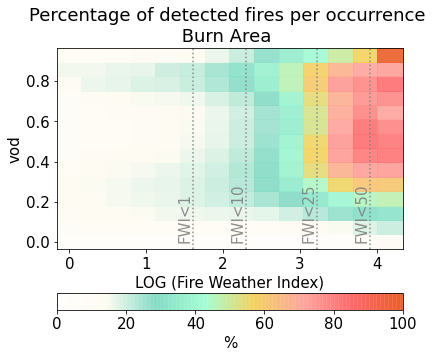

In [21]:
# choose between the two parameters to construct your plot 
# the recommended choice is veg='vod' and firetype='ba'
#==============================================================

veg='vod'
firetype='ba'
nrow=15
ncol=15
fwisteps=np.linspace(0, 4.5, ncol)
vegsteps=np.linspace(0, 1, nrow)

# all cases 

dft_all=training_df.copy()
aggdf_all=dft_all.groupby([pd.cut(dft_all["fwi"], fwisteps),
                           pd.cut(dft_all[veg], vegsteps)]).count().drop(columns=[veg,'fwi'])
aggdfreset_all = aggdf_all.reset_index()

aggdfpivot_all=aggdfreset_all.pivot('fwi', veg)
Z_all=aggdfpivot_all['dc'].values

# only cases when a fire occurred 

dft=training_df.copy()
dft=dft[dft[firetype]>0]

aggdf=dft.groupby([pd.cut(dft["fwi"], fwisteps),
                   pd.cut(dft[veg], vegsteps)]).count().drop(columns=[veg,'fwi'])
aggdfreset = aggdf.reset_index()

aggdfpivot=aggdfreset.pivot('fwi', veg)
Z=aggdfpivot[firetype].values

# resume the X and Y value 
X=aggdfpivot.columns.levels[1].values
X=pd.IntervalIndex(X).left

Y=aggdfpivot.index.values
Y=pd.IntervalIndex(Y).left
# mash grid for plotting 

Xi,Yi = np.meshgrid(X, Y)

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
current_cmap =get_continuous_cmap(hex_list);
current_cmap.set_bad(color='gray')
vmin,vmax = 0.0,100
norm = pltc.Normalize(vmin=vmin, vmax=vmax)
cp = ax.pcolormesh(Yi, Xi, 100*(Z.astype(np.float64)/Z_all.astype(np.float64)), 
                   alpha=0.9, shading='auto', norm=norm,cmap=current_cmap);
ax.axvline(np.log(25), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(25)-0.2,0.01,'FWI<25',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(50), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(50)-0.2,0.01,'FWI<50',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(10), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(10)-0.2,0.01,'FWI<10',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(5), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(5)-0.2,0.01,'FWI<1',rotation=90,
        alpha=0.9,color='gray')

# ax.clabel(cp, inline=True, fmt='%1.1f',
#           fontsize=10)
ax.set_title('Percentage of detected fires per occurrence \n Burn Area  ')
ax.set_xlabel('LOG (Fire Weather Index)')
ax.set_ylabel(veg)
plt.colorbar(cp, ax=ax, label="%", location='bottom')
plt.savefig('/home/nen/scripts/efi/fopi/fopi_vod_ba.svg', format='svg', dpi=1200)
plt.show()

In [27]:
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

veg='vod'
firetype='ba'
nrow=15
ncol=15
fwisteps=np.linspace(0, 4.5, ncol)
vegsteps=np.linspace(0, 1, nrow)

# all cases 

dft_all=training_df.copy()
aggdf_all=dft_all.groupby([pd.cut(dft_all["fwi"], fwisteps),
                           pd.cut(dft_all[veg], vegsteps)]).count().drop(columns=[veg,'fwi'])
aggdfreset_all = aggdf_all.reset_index()

aggdfpivot_all=aggdfreset_all.pivot('fwi', veg)
Z_all=aggdfpivot_all['dc'].values

# only cases when a fire occurred 

dft=training_df.copy()
dft=dft[dft[firetype]>0]


aggdf=dft.groupby([pd.cut(dft["fwi"], fwisteps),
                   pd.cut(dft[veg], vegsteps)]).count().drop(columns=[veg,'fwi'])
aggdfreset = aggdf.reset_index()

aggdfpivot=aggdfreset.pivot('fwi', veg)
Z=aggdfpivot[firetype].values
# resume the X and Y value 
#print(aggdfpivot)
#X is VEG
X=aggdfpivot.columns.levels[1].values
X=pd.IntervalIndex(X).left
print(X)
#Y is FWI
Y=aggdfpivot.index.values
Y=pd.IntervalIndex(Y).left
# mash grid for plotting 

Xi,Yi = np.meshgrid(X, Y)

# Our function to fit is going to be an exponenet 

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _dfi(M,F, a,b,x0,y0):
    F=1
    x, y = M   
    arr = np.zeros(x.shape)
    arr = F*np.exp( -((x-x0)/a)**4 -((y-y0)/b)**4)
   # arr = 1/(1+F*np.exp( -((x-x0)/a)**2 +((y-y0)/b)**2))
    return arr


Z_dfi=Z.astype(np.float64)/Z_all.astype(np.float64)
guess_prms = [1, 0.5, 2, 0.5, 6]            
# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((Xi.ravel(), Yi.ravel()))
popt, pcov = curve_fit(_dfi, xdata, Z_dfi.ravel(),guess_prms)
F,a,b,x0,y0 =popt

best_fit = np.zeros(Z_dfi.shape)
Mi=Xi,Yi
best_fit = _dfi(Mi,F,a,b,x0,y0)
print('Fitted parameters:')
print(popt)
rms = np.sqrt(np.mean((Z_dfi - best_fit)**2))
print('RMS residual =', rms)



                          af                                                \
vod            (0.0, 0.0714] (0.0714, 0.143] (0.143, 0.214] (0.214, 0.286]   
fwi                                                                          
(0.0, 0.321]              42             939           2647           3093   
(0.321, 0.643]            58            1231           3494           4114   
(0.643, 0.964]            88            1678           4577           5453   
(0.964, 1.286]           103            2323           5895           7103   
(1.286, 1.607]           142            3148           8128           8859   
(1.607, 1.929]           205            4008          10103          11144   
(1.929, 2.25]            221            5096          12054          13902   
(2.25, 2.571]            281            6234          14593          17338   
(2.571, 2.893]           350            8010          18351          22702   
(2.893, 3.214]           533           11312          25302     

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Results from running curve fit with different combinations of parameter 




#VOD and FWI (AF)
#Fitted parameters:
#[1.         0.39726258 5.05767464 0.62439397 8.68935765]

#RMS residual = 0.030322068580235315
#VOD and FWI (BA)
# Fitted parameters:
#[1.         0.56716912 3.11504565 0.64580504 5.47653683]
#RMS residual = 0.0762256324290762
#LAI and FWI (BA)
#Fitted parameters:
#[ 1.          0.66125185  9.86816807  0.68516909 12.63478849]
#RMS residual = 0.04465352461179391

#LAI and FWI (AF)
#[ 1.          0.77935388  8.64351661  0.92774191 13.38913832]
#RMS residual = 0.016682183038924558

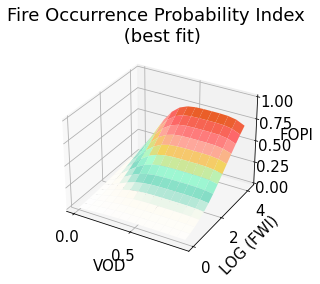

In [11]:
# Plot the 3D figure of the fitted function and the residuals.

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(Xi, Yi,best_fit, cmap=get_continuous_cmap(hex_list))
ax.set_zlim(0,1)
ax.set_title('Fire Occurrence Probability Index \n (best fit)')
ax.set_ylabel('LOG (FWI)')
ax.set_zlabel('FOPI')
ax.set_xlabel('VOD')

plt.savefig('/home/nen/scripts/efi/fopi/3Dsurf_vod_af_fit.svg', format='svg', dpi=1200)
plt.show()

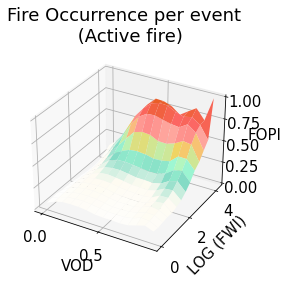

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(Xi, Yi,Z_dfi, cmap=get_continuous_cmap(hex_list))

ax.set_zlim(0,1)
ax.set_title('Fire Occurrence per event \n (Active fire)')
ax.set_ylabel('LOG (FWI)')
ax.set_zlabel('FOPI')
ax.set_xlabel('VOD')

plt.savefig('/home/nen/scripts/efi/fopi/3Dsurf_vod_af_data.svg', format='svg', dpi=1200)
plt.show()

Fitted parameters:


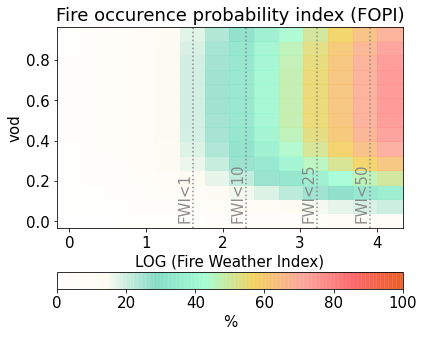

In [13]:
# Best fit 

Mi=Xi,Yi

best_fit = _dfi(Mi,F,a,b,x0,y0)
print('Fitted parameters:')
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
current_cmap =get_continuous_cmap(hex_list);
current_cmap.set_bad(color='gray')
vmin,vmax = 0.0,100
norm = pltc.Normalize(vmin=vmin, vmax=vmax)
cp = ax.pcolormesh(Yi, Xi, 100*(best_fit), 
                   alpha=0.9, shading='auto', norm=norm,cmap=current_cmap);

ax.axvline(np.log(25), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(25)-0.2,0.01,'FWI<25',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(50), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(50)-0.2,0.01,'FWI<50',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(10), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(10)-0.2,0.01,'FWI<10',rotation=90,
        alpha=0.9,color='gray')
ax.axvline(np.log(5), alpha=0.9,color='gray'
          ,linestyle=':')
ax.text(np.log(5)-0.2,0.01,'FWI<1',rotation=90,
        alpha=0.9,color='gray')

# ax.clabel(cp, inline=True, fmt='%1.1f',
#           fontsize=10)
ax.set_title('Fire occurence probability index (FOPI)')
ax.set_xlabel('LOG (Fire Weather Index)')
ax.set_ylabel(veg)
plt.colorbar(cp, ax=ax, label="%", location='bottom')
plt.savefig('/home/nen/scripts/efi/fopi/fopi_lai_best_fit.svg', format='svg', dpi=1200)
plt.show()




Testing 


This section contains the ROC and Reliability ananlysis 


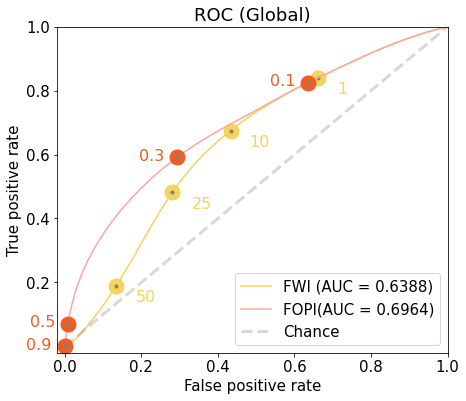

In [22]:
from sklearn import metrics

# VOD best fit see paper 
#F,a,b,x0,y0=1,0.6,3.1,0.6,5.5
# LAI best fit 
F,a,b,x0,y0=1,0.7,9.8,0.7,12.6

dfver=testing_df.copy()

Ms=dfver['vod'],np.log(dfver['fwi'])
dfver['fopi']= _dfi(Ms,F,a,b,x0,y0)

df_forest=dfver.loc[dfver['Bio_Names'] == 'Forest']
df_savana=dfver.loc[dfver['Bio_Names'] == 'Savanna']
df_agri=dfver.loc[dfver['Bio_Names'] == 'Agriculture']
#dfver=df_savana
th_ref_fwi=np.array([50,25,10,1])
th_ref_fopi=np.array([0.9,0.5,0.3,0.1])
nth=len(th_ref_fwi)
y_true= np.array(dfver['ba'])
y_true=(y_true > 0).astype(int)
y_fwi=np.array(dfver['fwi'])
y_fopi=np.array(dfver['fopi'])

fpr_fwi, tpr_fwi, th_fwi= metrics.roc_curve(y_true, y_fwi,drop_intermediate=True)
fpr_fopi, tpr_fopi, th_fopi= metrics.roc_curve(y_true, y_fopi,drop_intermediate=True)
auc_score_fwi = metrics.auc(fpr_fwi, tpr_fwi)
auc_score_fopi = metrics.auc(fpr_fopi, tpr_fopi)


plt.figure(figsize=(7, 6))

plt.plot(fpr_fwi, tpr_fwi, color=hex_list[4],
        label='FWI (AUC = %0.4f)' % auc_score_fwi)
for i in range(0, nth):
    index=np.argmax(th_fwi.round(0) == th_ref_fwi[i])
    plt.text(fpr_fwi[index] + 0.05, tpr_fwi[index] - 0.05, str(th_ref_fwi[i]), fontdict={'size': 16}, color=hex_list[4])
    plt.plot(fpr_fwi[index], tpr_fwi[index] ,'o', color=hex_list[4],markersize=15)
    plt.plot(fpr_fwi[index], tpr_fwi[index] ,'o', color='gray',markersize=3)

plt.plot(fpr_fopi, tpr_fopi, color=hex_list[5],
        label='FOPI(AUC = %0.4f)' % auc_score_fopi)
for i in range(0, nth):
    index=np.argmax(th_fopi.round(2) == th_ref_fopi[i]) 
    plt.text(fpr_fopi[index] - 0.1, tpr_fopi[index] - 0.01, str(th_ref_fopi[i]), fontdict={'size': 16}, color=hex_list[7])
    plt.plot(fpr_fopi[index], tpr_fopi[index] ,'o', color=hex_list[7],markersize=15)
    plt.plot(fpr_fopi[index], tpr_fopi[index] ,'o', color='gray',markersize=3)

plt.plot([0, 1], [0, 1], linestyle="--", lw=3, color="gray", label="Chance", alpha=0.3)
plt.ylim(ymax=1,ymin=-0.02)  # this line
plt.xlim(xmax=1,xmin=-0.02)
plt.xticks(np.arange(0.0, 1.1, 0.2))
plt.yticks(np.arange(0.2, 1.1, 0.2))
plt.legend(loc='lower right',)
plt.title("ROC (Global)")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('/home/nen/scripts/efi/fopi/roc_all_vod.svg', format='svg', dpi=1200)
plt.show()

#dfver=dfver.drop(columns=['bui','bio','ffmc','dc','dmc','isi','Bio_Names'])

One interesting aspects of the FOPI is that it correlates with the fire evemt as by construction is derived using observed fires 

         oe           fwi          fopi fwi_th  fopi_th
0         0  4.029687e+00  5.222768e-02   0-25  0.0-0.3
1         0  5.802344e+00  1.311441e-01   0-25  0.0-0.3
2         0  3.652507e+00  3.703736e-02   0-25  0.0-0.3
3         0  1.115381e+01  3.790108e-01   0-25  0.3-0.6
4         0  1.158105e+01  3.855856e-01   0-25  0.3-0.6
...      ..           ...           ...    ...      ...
2659336   0  6.445312e-02  5.723273e-22   0-25  0.0-0.3
2659337   0  5.273438e-02  3.830702e-24   0-25  0.0-0.3
2659338   0  1.395833e-01  4.357681e-15   0-25  0.0-0.3
2659339   0  1.402181e-01  5.104054e-15   0-25  0.0-0.3
2659340   0  1.866526e-09  0.000000e+00   0-25  0.0-0.3

[2659341 rows x 5 columns]
[0.12538063 0.21288767 0.45151023 0.78358209]


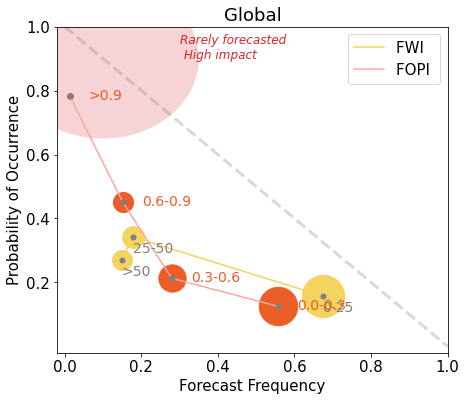

In [24]:
from sklearn.calibration import calibration_curve
from matplotlib.patches import Ellipse
# to one dimension.
# VOD best fit see paper 
#reccomended best fit parameter 

F,a,b,x0,y0=1. , 0.56716912 ,3.11504565 ,0.64580504 ,5.47653683

def _dfi(M,F, a,b,x0,y0):
    F=1
    x, y = M   
    arr = np.zeros(x.shape)
    arr = F*np.exp( -((x-x0)/a)**4 -((y-y0)/b)**4)
    return arr

dfver=testing_df.copy()

Ms=dfver['vod'],np.log(dfver['fwi'])
dfver['fopi']= _dfi(Ms,F,a,b,x0,y0)
df_forest=dfver.loc[dfver['Bio_Names'] == 'Forest']
df_savana=dfver.loc[dfver['Bio_Names'] == 'Savanna']
df_agri=dfver.loc[dfver['Bio_Names'] == 'Agriculture']
#dfver=df_agri


y_true= np.array(dfver['ba'])
y_true=(y_true > 0).astype(int)

y_fwi=np.array(dfver['fwi'])


y_fopi=np.array(dfver['fopi'])
#oe=occurred event
df = pd.DataFrame({'oe':y_true, 'fwi':y_fwi,'fopi':y_fopi})


fwi_intervals=np.array([0.,10.,25.,50.,100.,200.])
fwi_midpoint=(fwi_intervals[1:] + fwi_intervals[:-1]) / 2
nsample=float(len(y_true))

df['fwi_th']=np.nan

fwi_condition = [
    df['fwi'].ge(0) & df['fwi'].le(25),
    df['fwi'].gt(25) & df['fwi'].le(50),
    df['fwi'].gt(50) 
]
 
fwi_choices = ['0-25','25-50','>50']
  
df['fwi_th'] = np.select(fwi_condition, fwi_choices, default=np.nan)
    
df['fopi_th']=np.nan

fopi_condition = [
    df['fopi'].ge(0) & df['fopi'].le(0.3),
    df['fopi'].gt(0.3) & df['fopi'].le(0.6),
    df['fopi'].gt(0.6) & df['fopi'].le(0.9),
    df['fopi'].gt(0.9) 
]
 
fopi_choices = ['0.0-0.3','0.3-0.6','0.6-0.9','>0.9']
  
df['fopi_th'] = np.select(fopi_condition, fopi_choices, default=np.nan)
     
    
print(df)

#forecast frequency per choices
fwi_ff=(df.groupby(['fwi_th'])['fwi'].count().values) / nsample
fwi_sample=(df.groupby(['fwi_th'])['fwi'].count().values)
#probability of occurrence
fwi_po=(df.groupby(['fwi_th','oe'])['fwi'].count().values)
# po is composed of true and false in couples so we need to calculate
#the probability of occurence normalised by the total event in that category 
fwi_po=fwi_po[1::2]/(fwi_po[1::2]+fwi_po[:-1:2])

# now the same for FOPI

#forecast frequency per choices
fopi_ff=(df.groupby(['fopi_th'])['fopi'].count().values) / nsample
fopi_sample=(df.groupby(['fopi_th'])['fopi'].count().values)
#probability of occurrence
fopi_po=(df.groupby(['fopi_th','oe'])['fopi'].count().values)
# po is composed of true and false in couples so we need to calculate
#the probability of occurence normalised by the total event in that category 
fopi_po=fopi_po[1::2]/(fopi_po[1::2]+fopi_po[:-1:2])
print(fopi_po)


fwireldf=pd.DataFrame(data={'th':fwi_choices,'ff':fwi_ff,'po':fwi_po,'sample':fwi_sample})
fopireldf=pd.DataFrame(data={'th':fopi_choices,'ff':fopi_ff,'po':fopi_po,'sample':fopi_sample})

fig=plt.figure(figsize=(7, 6))
ax=fig.add_subplot(1,1,1)
ax.plot(fwireldf['ff'], fwireldf['po'], color=hex_list[4],
        label='FWI ' )
for i in range(0, len(fwi_choices)):
    ax.text(fwireldf['ff'][i]+0.0, fwireldf['po'][i]-0.05, str(fwi_choices[i]), fontdict={'size': 14}, color='gray')
    ax.scatter(fwireldf['ff'][i], fwireldf['po'][i] ,s=(fwireldf['sample'][i])/1000., color=hex_list[4])
#     plt.plot(fpr_fwi[index], tpr_fwi[index] ,'o', color='gray',markersize=3)
    ax.plot(fwireldf['ff'][i], fwireldf['po'][i] ,'o', color='gray',markersize=5)

ax.plot(fopireldf['ff'], fopireldf['po'], color=hex_list[5],
        label='FOPI ' )
for i in range(0, len(fopi_choices)):
    ax.text(fopireldf['ff'][i] +0.05, fopireldf['po'][i]-0.011, str(fopi_choices[i]), fontdict={'size': 14}, color=hex_list[7])
    ax.scatter(fopireldf['ff'][i], fopireldf['po'][i] ,s=(fopireldf['sample'][i])/1000., color=hex_list[7])
    ax.plot(fopireldf['ff'][i], fopireldf['po'][i] ,'o', color='gray',markersize=5)
#make an ellix on high impact low probabilities

ells = Ellipse((0.1,0.9), height=0.5, width=0.5, angle=0)
ells.set_alpha(0.2)
ells.set_facecolor("tab:red")

ax.add_patch(ells)
ax.annotate("Rarely forecasted \n High impact", xy=(0.2,0.9), xytext=(0.3, 0.9),size=12, style='italic', color="tab:red")

ax.plot([0, 1], [1, 0], linestyle="--", lw=3, color="gray", label="", alpha=0.3)
plt.ylim(ymax=1,ymin=-0.02)  # this line
plt.xlim(xmax=1,xmin=-0.02)
plt.xticks(np.arange(0.0, 1.1, 0.2))
plt.yticks(np.arange(0.2, 1.1, 0.2))
ax.legend(loc='upper right',)
plt.title("Global")
plt.xlabel("Forecast Frequency")
plt.ylabel("Probability of Occurrence")
plt.savefig('/home/nen/scripts/efi/reliability_all.svg', format='svg', dpi=1200)
plt.show()


#prob_true, prob_fwi = calibration_curve(y_true, y_fopi, strategy='quantile',normalize=True,n_bins=10)
#plt.plot(prob_true, prob_fwi,'o', color=hex_list[4])      
#plt.show()

Extra plot Correlation between variables 

In [17]:
from sklearn.calibration import calibration_curve

1.0 0.56716912 3.11504565 0.64580504 5.47653683


<Figure size 432x360 with 0 Axes>

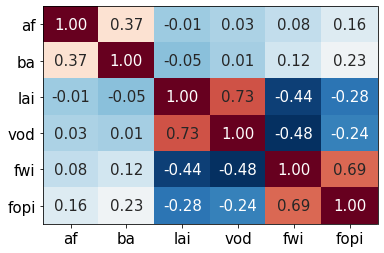

In [26]:
import colorsys
fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
#ax = fig.add_axes([left, bottom, width, height]) 

#ax[1.         0.5319547  6.45342153 0.63725439 8.87162378]
print(F,a,b,x0,y0)
dfver=testing_df.copy()
Ms=np.log(dfver['fwi']),dfver['vod']
Ms=dfver['vod'],np.log(dfver['fwi'])
dfver['fopi']= _dfi(Ms,F,a,b,x0,y0)

dfver=dfver.drop(columns=['bui','bio','ffmc','dc','dmc','isi','Bio_Names'])
cols = dfver.columns.tolist()
cols=['af', 'ba', 'lai', 'vod', 'fwi','fopi']

dfver=dfver[cols]
corr=dfver.corr()
# Fill diagonal and upper half with NaNs
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan

fig, ax = plt.subplots()
data = corr.values
heatmap = ax.pcolor(data, cmap=plt.get_cmap('RdBu_r'), 
                    vmin=np.nanmin(data), vmax=np.nanmax(data))
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)
ax.invert_yaxis()
row_labels = corr.index
column_labels = corr.columns
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

def _annotate_heatmap(ax, mesh):
    """
    **Taken from seaborn/matrix.py**
    Add textual labels with the value in each cell.
    """
    mesh.update_scalarmappable()
    xpos, ypos = np.meshgrid(ax.get_xticks(), ax.get_yticks())
    for x, y, val, color in zip(xpos.flat, ypos.flat,
                                mesh.get_array(), mesh.get_facecolors()):
        if val is not np.ma.masked:
            _, l, _ = colorsys.rgb_to_hls(*color[:3])
            text_color = ".15" if l > .5 else "w"
            val = ("{:.2f}").format(val)
            text_kwargs = dict(color=text_color, ha="center", va="center")
            # text_kwargs.update(self.annot_kws)
            ax.text(x, y, val, **text_kwargs)

_annotate_heatmap(ax, heatmap)

plt.savefig('/home/nen/scripts/efi/fopi/correlation_matrix.svg', format='svg', dpi=1200)
corr.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).highlight_null(null_color='#f1f1f1').set_precision(2)
plt.show()